In [30]:
import os
import sys

import uuid
import pickle

import pandas as pd

import mlflow

from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline

In [31]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")

In [32]:
# Create unique ids
def generate_uuids(n):
    ride_ids = []
    for i in range(n):
        ride_ids.append(str(uuid.uuid4()))
    return ride_ids

In [33]:
generate_uuids(3)

['780330a6-9db9-449e-8b58-be4087e12a2e',
 'f1e96586-ae6b-4a03-ad68-3eaf7bc45a77',
 '6135995a-e1c8-4420-9127-3e914ddda8a8']

In [34]:
def read_dataframe(filename: str):
    df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.dt.total_seconds() / 60
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    
    df['ride_id'] = generate_uuids(len(df))

    return df

def prepare_dictionaries(df: pd.DataFrame):
    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    #df['PU_DO'] = df['PULocationID'] + '_' + df['DOLocationID']
    #categorical = ['PU_DO']
    # i used another model
    
    numerical = ['trip_distance']
    dicts = df[categorical + numerical].to_dict(orient='records')
    return dicts


def load_model(run_id):
    #logged_model = f's3://mlflow-models-alexey/1/{run_id}/artifacts/model'
    #logged_model  = f"runs:/{run_id}/models_pickle"
    #logged_model = f"runs:/{run_id}/model"
    #logged_model = f"Users/Usuario/Desktop/ML Zoomcamp/2.ML Flow/mlruns/1/{run_id}/artifacts/models_pickle/"
    #logged_model = f"file:/Users/Usuario/Desktop/ML Zoomcamp/2.ML Flow/mlruns/1/{run_id}/artifacts/model"
    logged_model = f'runs:/b5eb4a60a4934bba8ccd86bf71d3f9fa/models_pickle'
    print(logged_model)
    model = mlflow.pyfunc.load_model(logged_model)
    return model

In [35]:
def apply_model(input_file, run_id, output_file):
    print(f'reading the data from {input_file}...')
    df = read_dataframe(input_file)
    dicts = prepare_dictionaries(df)

    print(f'loading the model with RUN_ID={run_id}...')
    model = load_model(run_id)

    print(f'applying the model...')
    y_pred = model.predict(dicts)

    print(f'saving the result to {output_file}...')
    df_result = pd.DataFrame()
    df_result['ride_id'] = df['ride_id']
    df_result['lpep_pickup_datetime'] = df['lpep_pickup_datetime']
    df_result['PULocationID'] = df['PULocationID']
    df_result['DOLocationID'] = df['DOLocationID']
    df_result['actual_duration'] = df['duration']
    df_result['predicted_duration'] = y_pred
    df_result['diff'] = df_result['actual_duration'] - df_result['predicted_duration']
    df_result['model_version'] = run_id
    
    print(output_file)
    df_result.to_parquet(output_file, index=False)
    df_result.to_csv(output_file.replace('.parquet', '.csv'), index=False, sep=';')


In [36]:
def run():
    #taxi_type = sys.argv[1] # 'green'
    #year = int(sys.argv[2]) # 2021
    #month = int(sys.argv[3]) # 3
    
    taxi_type = 'green'
    year = 2021
    month =  3
    
    input_file = f'data/{taxi_type}_tripdata_{year:04d}-{month:02d}.parquet'
    #output_file = f'output/{taxi_type}/{year:04d}-{month:02d}.parquet'
    output_file = f'output/{taxi_type}_tripdata_{year:04d}-{month:02d}.parquet'

    #run_id = sys.argv[4] # 'e1efc53e9bd149078b0c12aeaa6365df'
    run_id ='6ce6efecdd8e4805884aaae93fa3348c'

    apply_model(
        input_file=input_file,
        run_id=run_id,
        output_file=output_file
    )

In [37]:
run()

reading the data from data/green_tripdata_2021-03.parquet...
loading the model with RUN_ID=6ce6efecdd8e4805884aaae93fa3348c...
runs:/b5eb4a60a4934bba8ccd86bf71d3f9fa/models_pickle
applying the model...
saving the result to output/green_tripdata_2021-03.parquet...
output/green_tripdata_2021-03.parquet


In [39]:
df_results = pd.read_csv('output/green_tripdata_2021-03.csv', sep=';')

y_true = df_results['actual_duration']
y_pred = df_results['predicted_duration']

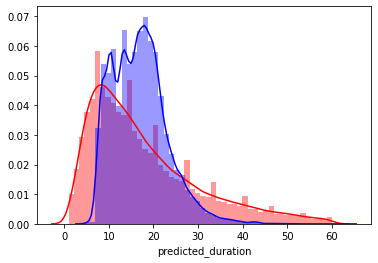

In [40]:
import seaborn as sns

sns.distplot(y_true, color='red')
sns.distplot(y_pred, color='blue')

In [41]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_true, y_pred, squared=False)

10.531285218710012